# 딥러닝 모델을 활용하여 metats pipeline 구축

In [1]:
import pandas as pd 
import numpy as np
import tensorflow as tf
from tensorflow.python.keras.models import load_model
from tensorflow import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## pipeline에 입력할 데이터 형식으로 변환 ( 24시간동안의 데이터를 사용하도록 )

In [2]:
def build_dataset(seq_length):
    address1="./Merged_Data/train_x.csv"
    df1 = pd.read_csv(address1).drop("time",axis=1)
    
    time_series_x = df1.values
    dataX = []
    
    for i in range(0, len(time_series_x)-seq_length):
        _x = time_series_x[i:i+seq_length, :]
        dataX.append(_x)

    return np.array(dataX)

In [3]:
data=build_dataset(25)

In [4]:
data.shape

(55202, 25, 5)

## metats pipeline 작성

In [5]:
from metats.pipeline import MetaLearning

pipeline = MetaLearning(method='selection', loss='mse')

### Meta Feature를 추출하는 Feature Extractor (AutoEncoder, TsFresh)

In [6]:
from metats.features.unsupervised import DeepAutoEncoder
from metats.features.deep import AutoEncoder, MLPEncoder, MLPDecoder

enc = MLPEncoder(input_size=5, input_length=24, latent_size=8, hidden_layers=(16,))
dec = MLPDecoder(input_size=5, input_length=24, latent_size=8, hidden_layers=(16,))

ae = AutoEncoder(encoder=enc, decoder=dec)
ae_features = DeepAutoEncoder(auto_encoder=ae, epochs=200, verbose=True)

c:\Users\heeji\anaconda3\envs\meta\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
from metats.features.statistical import TsFresh

stat_features = TsFresh()
pipeline.add_feature(stat_features)

### pipeline에 forecaster(LSTM, Attention_LSTM, Dual_Attention_LSTM) 연결

In [8]:
forecaster1  = load_model('../Model_Training/Saved_Model/LSTM(epoch=100).pt')

forecaster2 = load_model('../Model_Training/Saved_Model/Attention_LSTM(epoch=100).pt')

forecaster3 = load_model('../Model_Training/Saved_Model/Dual_Attention_LSTM(epoch=100).pt')

pipeline.add_forecaster(forecaster1)
pipeline.add_forecaster(forecaster2)
pipeline.add_forecaster(forecaster3)

### Best Forecaster를 결정하는 MetaLearner(RandomForestClassifier) 설정

In [9]:
from sklearn.ensemble import RandomForestClassifier
pipeline.add_metalearner(RandomForestClassifier())

## pipeline fit

In [10]:
pipeline.fit(data,fh=1)

test


## test 데이터 load, 형식에 맞게 변환

In [11]:
def build_testset(seq_length):
    address1="./Merged_Data/test_x.csv"
    df1 = pd.read_csv(address1).drop("time",axis=1)
    address2="./Merged_Data/test_y.csv"
    df2 = pd.read_csv(address2)
    
    time_series_x = df1.values
    time_series_y = df2.values
    dataX = []
    dataY = []
    
    for i in range(0, len(time_series_x)-seq_length):
        _x = time_series_x[i:i+seq_length, :]
        _y = time_series_y[i+seq_length-1]
        
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

In [12]:
test_x,test_y=build_testset(24)

## test데이터로 예측

In [14]:
pred=pipeline.predict(test_x,1)

test


## scaler를 호출하여 inverse tranform 적용

In [17]:
import joblib
scaler=joblib.load("../Merged_Data/Scaler/Y_pm10.pkl")

inv_test_y=scaler.inverse_transform(test_y)
inv_pred=scaler.inverse_transform(pred[0])

## 결과 시각화(앞 200개의 데이터만)

In [19]:
import matplotlib.pyplot as plt
import numpy as np

def vizualization_self(train_term,test_y,pred_y):

    plt.figure(figsize=(32, 16))
    plt.plot(np.arange(train_term), test_y[0:train_term], color='red', ls='-', lw=3, label='Real Test Data')
    plt.plot(np.arange(train_term), pred_y[0:train_term], color='blue', ls='--', lw=3, label='Predict Test Data')
    plt.xlabel('[Time]', fontsize=25, fontweight='bold')
    plt.ylabel('[PM10]', fontsize=25, fontweight='bold')
    plt.title('Predict',fontsize=30, weight='bold')
    plt.xticks( fontsize=15, fontweight='bold')
    plt.yticks( fontsize=15, fontweight='bold')
    plt.grid(True)
    plt.legend()
    return

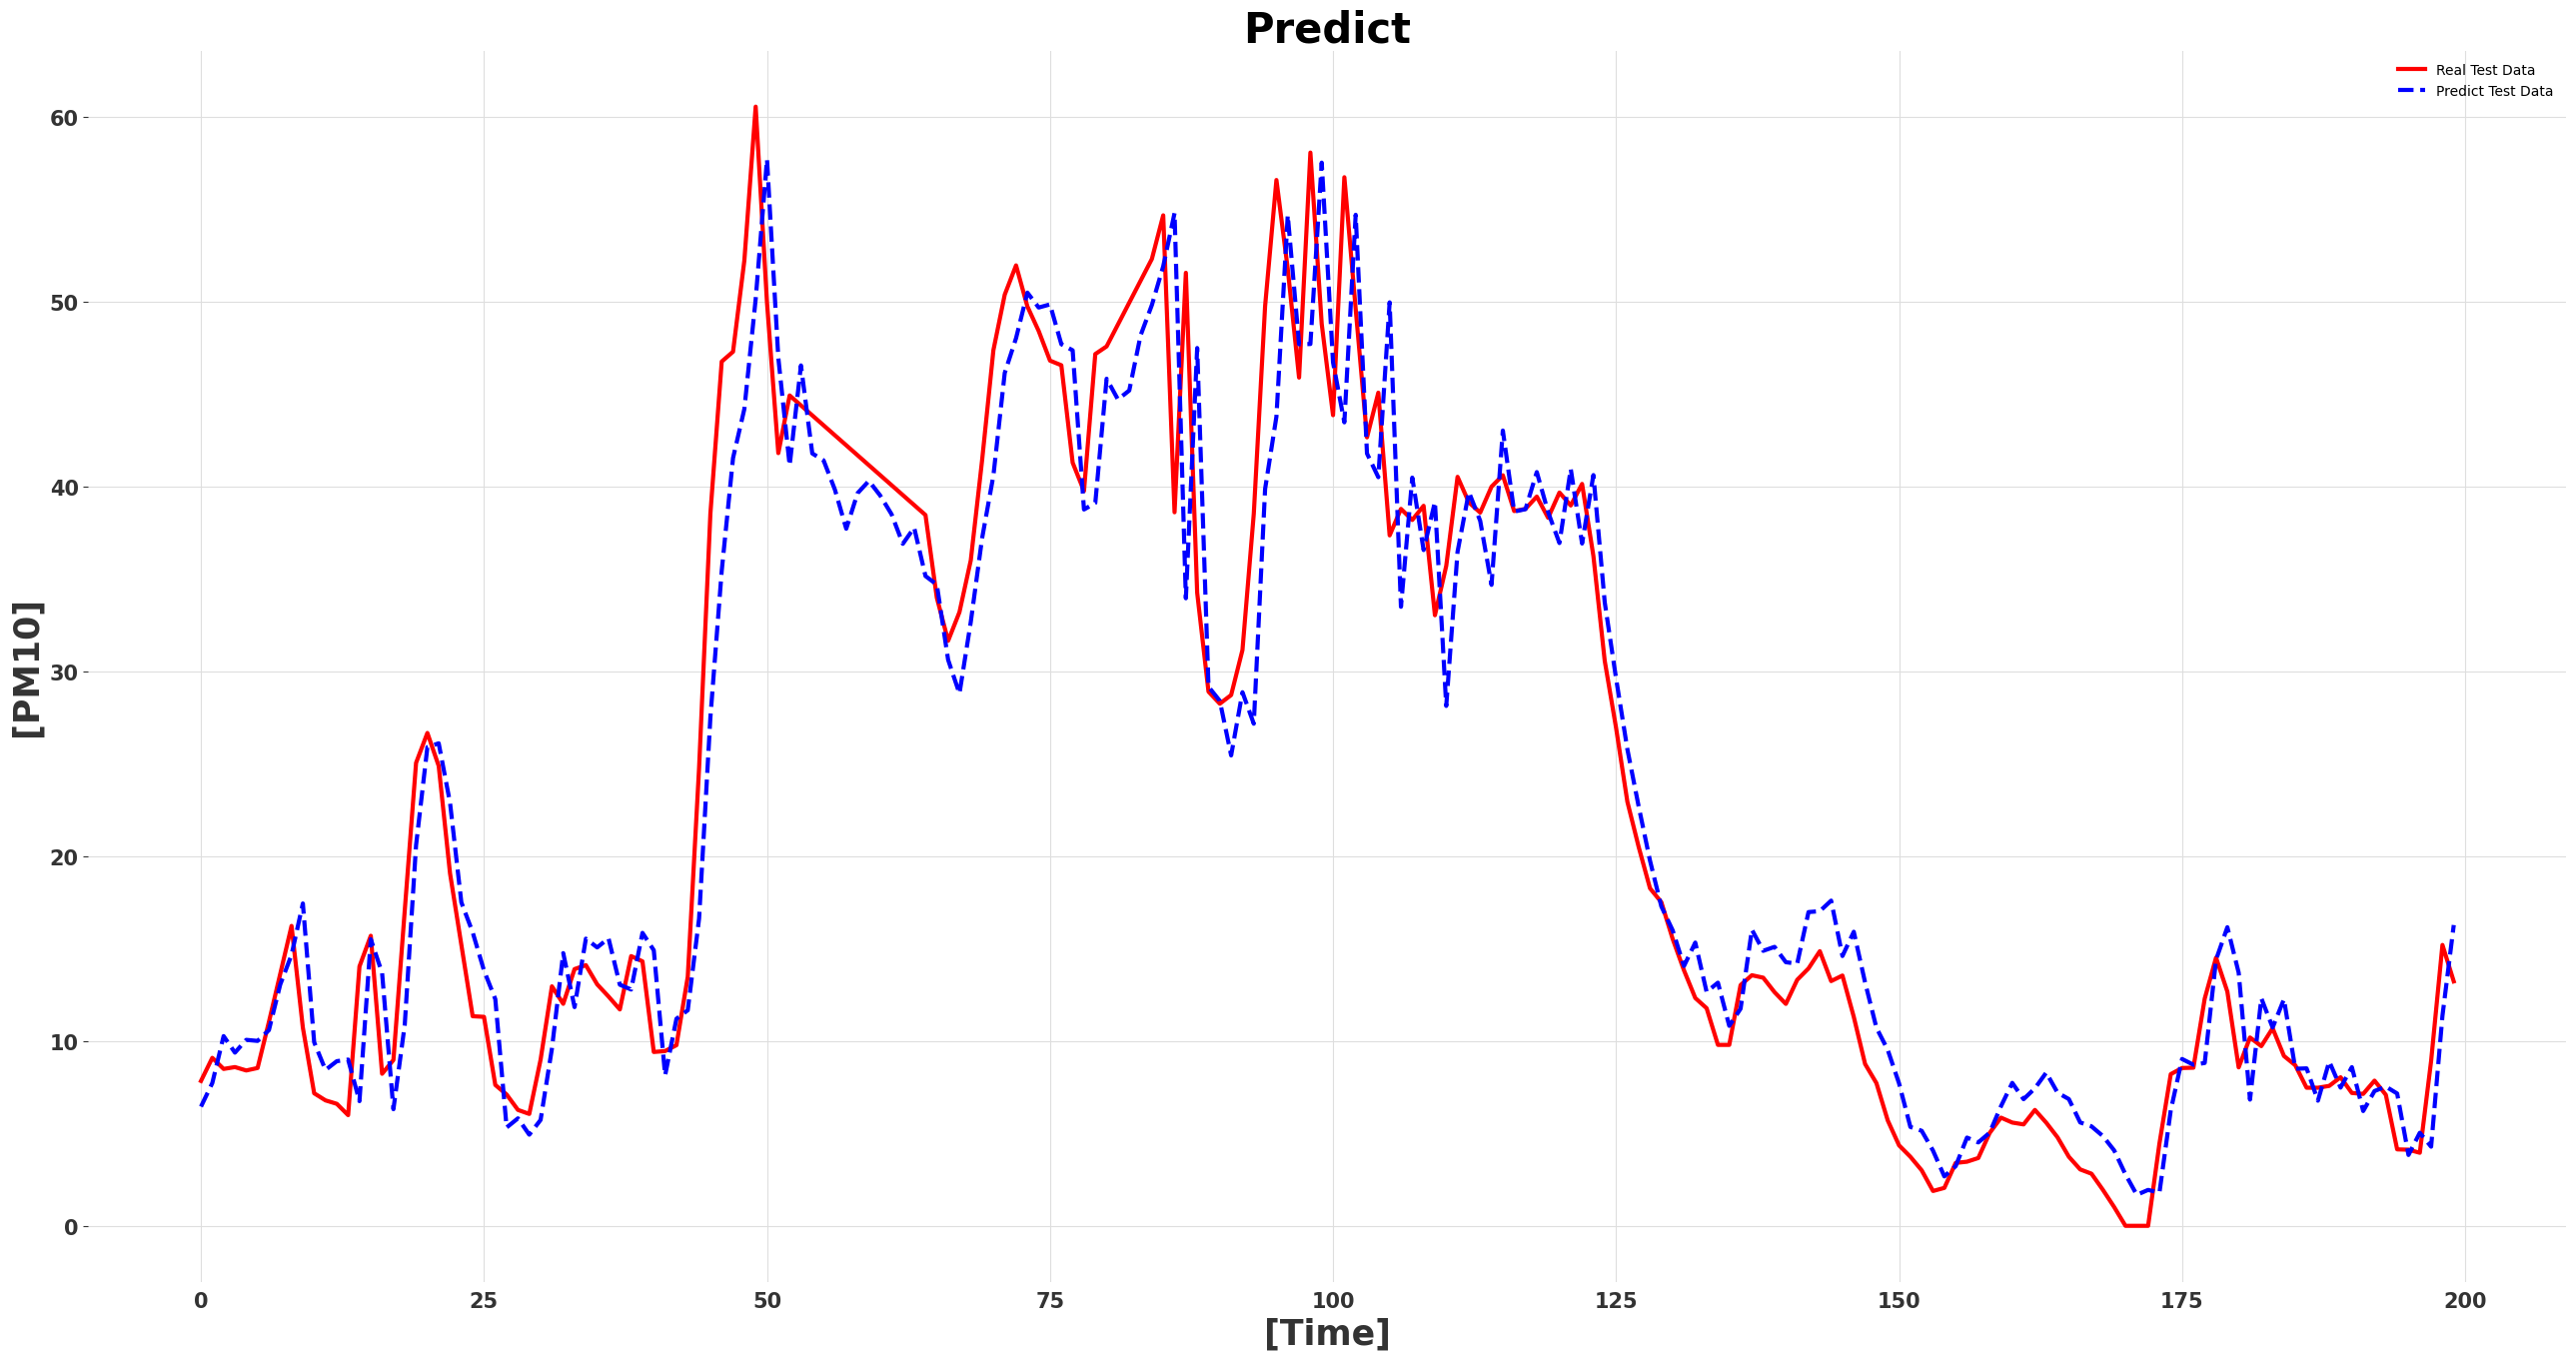

In [21]:
vizualization_self(200,inv_test_y,inv_pred)

## 평가 지표 : SMAPE

In [22]:
def Symmetric_mean_absolute_percentage_error(actual, predicted):
    import numpy as np
    total=len(actual)
    numerator=np.abs(actual-predicted)
    denominator=np.abs(actual)+np.abs(predicted)
    SMAPE=(100/total)*np.sum(numerator/denominator)
    
    return SMAPE

In [24]:
score=Symmetric_mean_absolute_percentage_error(inv_test_y,inv_pred)
100-score

91.59022811111902